Aufgabe 2:

- Training einer Logistischen Regression zur Klassifizierung der Digits (Evtl. mit der Klassifizierung einer Digit beginnen)

- Berechnung der Test-Fehler

- Anpassung der Inputdaten (Feature Engineering: Bildblöcke, quantisierte Grauwerte )

- ‘Negative Log Loss’ auf den Testdaten ist entscheidend

In [68]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from IPython.display import display, HTML
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,log_loss,r2_score,roc_curve, roc_auc_score,auc
from sklearn.model_selection import train_test_split
import pickle
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
data_train = pd.read_csv("Daten/zip.train", header=None, sep=" ")
data_test = pd.read_csv("Daten/zip.test",header=None,sep=" ")

In [3]:
print(f"NaNs in data train: {data_train.isnull().sum().sum()}") #nr of nans
print(f" Shape of data train: {data_train.shape}")
print(f"NaNs in data test: {data_test.isnull().sum().sum()}")
print(f" Shape of data test: {data_test.shape}")

NaNs in data train: 7291
 Shape of data train: (7291, 258)
NaNs in data test: 0
 Shape of data test: (2007, 257)


In [4]:
# drop NaN col in data_train
data_train.drop(columns = [257],axis = 1,inplace = True)
print(data_train.isnull().sum().sum()) #nr of nans

0


In [5]:
data_train.rename(columns = {data_train.columns[0]: "target"},inplace=True)
data_test.rename(columns = {data_test.columns[0]: "target"}, inplace = True)

In [6]:
display(data_train.head())
display(data_test.head())

,target,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,7.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0


,target,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,9,-1.0,-1.0,-1.0,-1.000,-1.0,-0.948,-0.561,0.148,0.384,...,-1.000,-0.908,0.430,0.622,-0.973,-1.000,-1.0,-1.0,-1.0,-1.0
1,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2,3,-1.0,-1.0,-1.0,-0.593,0.7,1.000,1.000,1.000,1.000,...,1.000,0.717,0.333,0.162,-0.393,-1.000,-1.0,-1.0,-1.0,-1.0
3,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
4,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-0.858,-0.106,...,0.901,0.901,0.901,0.290,-0.369,-0.867,-1.0,-1.0,-1.0,-1.0


In [7]:
class Analysis: 
    def __init__(self):
        self.results = pd.DataFrame() # contains the predicted ys
        self.input_data = {} # dict of dicts, contains the input data frames
        self.algo_names = [] # list of all algo names that were added
        self.algos = {} # dict of dicts, contains the algo names and algos
        self.analysis_summaries = {} # contains all analyses that have already been run and details about them 
                                        # (i.e. which algo and input data was used)
    
    def add_algo(self, algo, algo_name):
        """adds a new algo including its configurations (e.g. n_neighbors). Needs to be
        given a unique name"""
        if algo_name not in self.algo_names:
            self.algo_names.append(algo_name)
            self.algos[algo_name] = {'algo_name': algo_name, 'algo': algo}
        else: print("This algo config already exists!!")
    
    
    def add_input_prep(self, input_data_name, train_input_data, test_input_data):
        """accepts input data name, a train df and test df, scales both and stores them in
        input_data"""
        if input_data_name not in self.input_data:
            self.input_data[input_data_name] = {"train_data": train_input_data,\
                                               "test_data": test_input_data}
            #split in train and test
            self.input_data[input_data_name]["train_X"] = self.input_data[input_data_name]["train_data"].loc[:, self.input_data[input_data_name]["train_data"].columns != "target"]
            self.input_data[input_data_name]["test_X"] = self.input_data[input_data_name]["test_data"].loc[:, self.input_data[input_data_name]["test_data"].columns != "target"]
            self.input_data[input_data_name]["train_y"] = self.input_data[input_data_name]["train_data"].loc[:, self.input_data[input_data_name]["train_data"].columns == "target"].values.flatten()        
            self.input_data[input_data_name]["test_y"] = self.input_data[input_data_name]["test_data"].loc[:, self.input_data[input_data_name]["test_data"].columns == "target"].values.flatten()
            
            nr_features = self.input_data[input_data_name]["train_X"].shape[1]
            
            #standard scaling of continuous variables
            scaler = preprocessing.StandardScaler()
            train_df_cont = self.input_data[input_data_name]["train_X"]
            scaler.fit(train_df_cont) 
            self.input_data[input_data_name]["train_X"] = scaler.transform(train_df_cont)
            self.input_data[input_data_name]["test_X"] = scaler.transform(self.input_data[input_data_name]["test_X"])
            
            return self.input_data
            
        else:
            print("Input data name already exists!")
    
    def run_analysis(self,analysis_name,input_data_name,algo_name,):
        """runs an analysis with a given input_data and algo_name. Calculates error rates and stores
        them in self.analysis_summaries. For LinReg, also calculates beta coefficients."""
        
        if analysis_name not in self.analysis_summaries:
            self.analysis_summaries[analysis_name] = {"input_data_name":input_data_name,"algo_name":algo_name,"fit":-1}
            
            # get the data from input_data
            train_X, test_X, train_y, test_y = self.input_data[input_data_name]["train_X"],\
                self.input_data[input_data_name]["test_X"],\
                self.input_data[input_data_name]["train_y"],\
                self.input_data[input_data_name]["test_y"]
            
            if self.analysis_summaries[analysis_name]['fit'] == -1:
                print("self analysis summary is -1")
                self.analysis_summaries[analysis_name]['fit'] = self.algos[algo_name]['algo'].fit(train_X, train_y) 
                pred = self.algos[algo_name]['algo'].predict(test_X)
                self.results[analysis_name] = pred 
                # error and r2 calculation
                mse= mean_squared_error(pred,test_y.flatten())
                rmse = np.sqrt(mse)
                self.analysis_summaries[analysis_name]["RMSE"] = rmse
                #R2 = self.analysis_summaries[analysis_name]['fit'].score(test_X, test_y)
                R2 = self.algos[algo_name]['algo'].score(test_X, test_y)
                r2_sc = r2_score(test_y,pred)
                self.analysis_summaries[analysis_name]["R2"] = r2_sc
                
                rss = (sum((pred - test_y)**2))
                tss = (sum((test_y.mean() - test_y)**2))
                r2_formel = 1-(rss/tss)
                rse = np.sqrt(rss/(test_X.shape[0]-test_X.shape[1]))
                self.analysis_summaries[analysis_name]["RSE"] = rse
                print(f"RSE: {rse}, RMSE: {rmse}, R2: {R2}, R2_score: {r2_sc},R2_formel: {r2_formel}")
                acc = (1.0*(test_y == pred.astype(int)).sum())/test_y.shape[0]
                print(f"acc: {acc}")
                self.analysis_summaries[analysis_name]["acc"] = acc
                if isinstance(self.algos[algo_name],linear_model.base.LinearRegression):
                    betas = self.analysis_summaries[analysis_name]['fit'].coef_
                    betas_df = pd.DataFrame(data = betas.reshape(1,train_X.shape[1]),columns = train_X.columns)
                    self.analysis_summaries[analysis_name]["betas"] = betas_df
                if isinstance(self.algos[algo_name]["algo"],linear_model.logistic.LogisticRegression):
                    probas = self.analysis_summaries[analysis_name]['fit'].predict_proba(test_X)
                    logloss = log_loss(test_y,probas)
                    self.analysis_summaries[analysis_name]["LogLoss"] = logloss
                    print(f"LogLoss: {logloss}")
                    print("Confusion Matrix:")
                    conf_matrix = confusion_matrix(test_y, pred)
                    display(conf_matrix)
                    #http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html
                
                
        else: print("Analysis name already exists!")
    
    def run_all_combis(self):
        for i in self.input_data.keys():
            for a in self.algos:
                ananame = str(a) + "_" + str(i)
                print(f"\nRunning {ananame} analysis...")
                self.run_analysis(ananame,i,a)
                print("Finished!")
                      
    def calculate_error_rates(self):
        """returns a df with R2, RMSE and RSE for each analysis (i.e. each combination of 
        input_data and algo that was run with run_analysis)"""
        rates = pd.DataFrame(columns = ["Input DF","Algo Name","R2","RMSE","RSE"],index = self.analysis_summaries.keys())
        for ana in self.analysis_summaries:
            rates.loc[ana,"Input DF"] = self.analysis_summaries[ana]["input_data_name"]
            rates.loc[ana,"Algo Name"] = self.analysis_summaries[ana]["algo_name"]
            rates.loc[ana,"R2"] = self.analysis_summaries[ana]["R2"]
            rates.loc[ana,"RMSE"] = self.analysis_summaries[ana]["RMSE"]
            rates.loc[ana,"RSE"] = self.analysis_summaries[ana]["RSE"]
            rates.loc[ana,"ACC"] = self.analysis_summaries[ana]["acc"]
            if "LogLoss" in self.analysis_summaries[ana]:
                rates.loc[ana,"LogLoss"] = self.analysis_summaries[ana]["LogLoss"]
        #display(rates)
        return rates
    
    def pretty_barplots(self):
        "prints a barplot sumarizing the error rates and R2 for the analyses that were run before"
        pass
            
    def delete_input_data(self,input_data_name):
        self.input_data.pop(input_data_name,None) # None means nothing happens if key not found
        print(f"{input_data_name} was deleted")
        
    def get_results(self):
        return self.results
        

In [8]:
analysis = Analysis()

In [9]:
analysis.add_input_prep("orig",data_train,data_test)

{'orig': {'train_data':       target      1      2      3      4      5      6      7      8      9  \
  0        6.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.631  0.862   
  1        5.0 -1.000 -1.000 -1.000 -0.813 -0.671 -0.809 -0.887 -0.671 -0.853   
  2        4.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000   
  3        7.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.273  0.684  0.960  0.450   
  4        3.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.928 -0.204  0.751  0.466   
  5        6.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.397  0.983 -0.535 -1.000   
  6        3.0 -1.000 -1.000 -1.000 -0.830  0.442  1.000  1.000  0.479 -0.328   
  7        1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  0.510 -0.213   
  8        0.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.454  0.879 -0.745 -1.000   
  9        1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.909  0.801   
  10       7.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.596  0.912  1.000  0.290   
  11  

In [10]:
#analysis.input_data["orig"]["train_X"][:,1].mean()

In [11]:
analysis.add_algo(KNeighborsClassifier(n_neighbors=5), 'KNN_5')

In [12]:
analysis.add_algo(linear_model.LogisticRegression(class_weight='balanced', random_state=42, solver='newton-cg', multi_class='multinomial'), 'LogRegMultinomial') 

In [13]:
#analysis.run_analysis("Multinomial_orig","orig","LogRegMultinomial")

In [14]:
analysis.run_all_combis()


Running KNN_5_orig analysis...
self analysis summary is -1
RSE: 1.1905778967187908, RMSE: 1.112057394754292, R2: 0.9267563527653214, R2_score: 0.86420207438725,R2_formel: 0.8642020743872498
acc: 0.9267563527653214
Finished!

Running LogRegMultinomial_orig analysis...
self analysis summary is -1
RSE: 1.2661295162926314, RMSE: 1.1826262651023, R2: 0.9138016940707524, R2_score: 0.8464203153928327,R2_formel: 0.8464203153928325
acc: 0.9138016940707524
LogLoss: 0.5836430088356019
Confusion Matrix:


array([[346,   0,   2,   3,   3,   1,   1,   0,   2,   1],
       [  0, 251,   1,   3,   3,   0,   3,   1,   1,   1],
       [  3,   0, 170,   4,   8,   2,   0,   2,   9,   0],
       [  1,   0,   3, 148,   1,  10,   0,   1,   1,   1],
       [  3,   1,   6,   1, 174,   3,   2,   2,   2,   6],
       [  3,   0,   0,   7,   1, 144,   1,   1,   1,   2],
       [  1,   0,   5,   0,   2,   3, 158,   0,   1,   0],
       [  0,   0,   2,   2,   7,   0,   0, 133,   0,   3],
       [  7,   0,   4,   2,   1,   7,   0,   1, 143,   1],
       [  0,   1,   0,   0,   3,   1,   0,   2,   3, 167]], dtype=int64)

Finished!


In [15]:
analysis.calculate_error_rates()

,Input DF,Algo Name,R2,RMSE,RSE,ACC,LogLoss
KNN_5_orig,orig,KNN_5,0.864202,1.11206,1.19058,0.926756,NaN
LogRegMultinomial_orig,orig,LogRegMultinomial,0.84642,1.18263,1.26613,0.913802,0.583643


# Removing outlier from training data

In [16]:
def get_digit_rows(data,digit): 
    """returns all rows of a given digit
        careful: first column (target digit) still included!!!"""
    rows = data[data["target"] == float(digit)]
    return pd.DataFrame(rows)

#display(get_digit_rows(data_train,2)) # testing the function

In [17]:
def get_digit_stat_array(data,digit,stat):
    """returns the (reshaped) 16x16 image for a given digit and statistic"""
    digit_rows = get_digit_rows(data,digit).iloc[:,1:]
    if stat == "mean":
        stat_row = digit_rows.mean()
    elif stat == "sd":
        stat_row = np.std(digit_rows)
    elif stat == "max":
        stat_row = np.max(digit_rows)
    elif stat == "min":
        stat_row = np.min(digit_rows)
    else: print("please enter a valid stat (mean,sd,max or min)")
    img = stat_row.values.reshape(16,16)
    return img

#display(get_digit_stat_array(data_train,8,"mean")) # testing the function

In [18]:
def outside_boundaries(myseries,lower,upper):
    """returns the number of elements of myseries which are outside the lower-upper range (lower and upper are also series)"""
    within_lims = myseries.between(lower,upper,inclusive=True)
    return myseries.shape[0] - sum(within_lims)

def identify_outlier_rows(data,digit,limit):
    """returns the image rows (=observations) for each digit which are very different from the other image rows. 
    Identifies image rows of a digit, where more than limit * pixels (limit ranges between 0 and 1) are outlier 
    pixels (outlier pixel = outside mean +- 2sd image values). E.g. if limit = 0.1 --> observations are identified 
    as outliers if 0.1 * 256 pixels are outside the mean +- 2sd range"""
    all_rows = get_digit_rows(data,digit).iloc[:,1:]
    nr_observations = all_rows.shape[0]
    nr_limit_pixels = limit * 256
    print(f"Nr of observations: {nr_observations}")
    print(f"If an observation (= a row of data) has more than {nr_limit_pixels} outlier pixels, it is identified as outlier observation")
    all_rows.columns = range(all_rows.shape[1]) # colnames müssen geändert werden, damit sie wieder von 0 bis ende gehen (statt bei 1 anzufangen)!
    #all_rows.index = range(nr_observations) 
    #display(all_rows)      
    mean_array = get_digit_stat_array(data,digit,"mean")
    sd_array = get_digit_stat_array(data,digit,"sd")
    upper_lim = pd.Series((mean_array + 2*sd_array).flatten()) # .flatten() and pd.Series reconvert the 16*16 array to a 256 Series
    lower_lim = pd.Series((mean_array - 2*sd_array).flatten())
    digit_nr_outlier_pixels = pd.Series(np.zeros(nr_observations))
    for i in range(0,nr_observations):
        digit_nr_outlier_pixels[i] = outside_boundaries(all_rows.iloc[i,:],lower_lim,upper_lim) 
    #print(f"Number of outlier pixels for each of the {nr_observations} observations: ")
    #display(digit_nr_outlier_pixels)
    which_row_is_outlier = digit_nr_outlier_pixels.gt(nr_limit_pixels)
    print(f"{sum(which_row_is_outlier)} outlier observations were identified for this digit.")
    infodf = pd.concat([lower_lim,pd.Series(mean_array.flatten()),upper_lim,all_rows.transpose()],axis=1)
    #with pd.option_context('display.max_rows', None, 'display.max_columns', 10): # shows the whole df 
        #display(infodf)
    which_row_is_outlier.index = all_rows.index
    return all_rows.loc[which_row_is_outlier]


display(identify_outlier_rows(data_train,1,0.15))

Nr of observations: 1005
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
7 outlier observations were identified for this digit.


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
917,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.706,0.700,-0.640,...,-0.209,0.843,-0.508,-1.000,-1.000,-1.000,-1.000,-1.00,-1.0,-1.0
2047,-1.0,-1.0,-1.0,-1.0,-1.0,-0.991,0.631,0.999,0.943,-0.101,...,-1.000,-1.000,-0.321,0.785,-0.269,-1.000,-1.000,-1.00,-1.0,-1.0
4903,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-0.446,0.957,...,-0.301,0.301,0.143,-0.334,-0.334,-0.334,-0.334,-0.53,-1.0,-1.0
5748,-1.0,-1.0,-1.0,-1.0,-1.0,-0.764,0.643,0.691,-0.013,-0.991,...,-1.000,-0.493,0.538,0.540,-0.504,-1.000,-1.000,-1.00,-1.0,-1.0
5749,-1.0,-1.0,-1.0,-1.0,-1.0,-0.341,0.990,0.786,-0.141,-0.953,...,-0.575,0.476,0.828,-0.812,-1.000,-1.000,-1.000,-1.00,-1.0,-1.0
6738,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.242,0.999,0.999,0.608,...,-1.000,-1.000,-0.811,0.201,0.717,-0.979,-1.000,-1.00,-1.0,-1.0
6963,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.551,0.585,0.999,...,-0.021,0.999,0.999,0.999,0.999,0.183,-1.000,-1.00,-1.0,-1.0


In [19]:
def remove_all_outlier_rows(data,limit):
    data_new = data.copy()
    for digit in range(0,10):
        outliers = identify_outlier_rows(data,digit,limit)
        data_new = data_new.loc[data_new.index.difference(outliers.index)]
    return data_new

In [20]:
cleaned_data_train = remove_all_outlier_rows(data_train,0.15)

Nr of observations: 1194
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
8 outlier observations were identified for this digit.
Nr of observations: 1005
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
7 outlier observations were identified for this digit.
Nr of observations: 731
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
3 outlier observations were identified for this digit.
Nr of observations: 658
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
17 outlier observations were identified for this digit.
Nr of observations: 652
If an observation (= a row of data) has more than 38.4 outlier pixels, it is identified as outlier observation
11 outlier observations were identified for this digit.
Nr of observations: 556
If an observation (= a

In [21]:
cleaned_data_train.shape

(7162, 257)

In [22]:
7291 - 129

7162

In [23]:
analysis.add_input_prep("no_outlier",cleaned_data_train,data_test)

{'orig': {'train_data':       target      1      2      3      4      5      6      7      8      9  \
  0        6.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.631  0.862   
  1        5.0 -1.000 -1.000 -1.000 -0.813 -0.671 -0.809 -0.887 -0.671 -0.853   
  2        4.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000   
  3        7.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.273  0.684  0.960  0.450   
  4        3.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.928 -0.204  0.751  0.466   
  5        6.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.397  0.983 -0.535 -1.000   
  6        3.0 -1.000 -1.000 -1.000 -0.830  0.442  1.000  1.000  0.479 -0.328   
  7        1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  0.510 -0.213   
  8        0.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.454  0.879 -0.745 -1.000   
  9        1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.909  0.801   
  10       7.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.596  0.912  1.000  0.290   
  11  

In [24]:
analysis.add_algo(KNeighborsClassifier(n_neighbors=5), 'KNN_5')

This algo config already exists!!


In [25]:
analysis.run_all_combis()


Running KNN_5_orig analysis...
Analysis name already exists!
Finished!

Running LogRegMultinomial_orig analysis...
Analysis name already exists!
Finished!

Running KNN_5_no_outlier analysis...
self analysis summary is -1
RSE: 1.220189946921247, RMSE: 1.1397164832458824, R2: 0.9257598405580468, R2_score: 0.8573629363124742,R2_formel: 0.8573629363124738
acc: 0.9257598405580468
Finished!

Running LogRegMultinomial_no_outlier analysis...
self analysis summary is -1
RSE: 1.2376171353108671, RMSE: 1.1559943209009105, R2: 0.9108121574489287, R2_score: 0.8532594534676086,R2_formel: 0.8532594534676083
acc: 0.9108121574489287
LogLoss: 0.6014698834451048
Confusion Matrix:


array([[348,   0,   4,   2,   2,   1,   0,   0,   1,   1],
       [  0, 249,   1,   3,   4,   0,   4,   1,   1,   1],
       [  4,   0, 178,   3,   4,   3,   0,   1,   4,   1],
       [  1,   0,   6, 142,   1,  12,   1,   1,   1,   1],
       [  3,   1,   8,   0, 175,   2,   2,   1,   3,   5],
       [  5,   0,   0,   5,   1, 141,   2,   1,   3,   2],
       [  2,   0,   3,   0,   3,   4, 158,   0,   0,   0],
       [  0,   0,   2,   1,   9,   0,   0, 132,   1,   2],
       [  6,   0,   4,   3,   2,   6,   1,   1, 140,   3],
       [  0,   1,   0,   0,   6,   1,   0,   1,   3, 165]], dtype=int64)

Finished!


In [26]:
analysis.calculate_error_rates().sort_values(["R2","RMSE"],ascending=[False,True])

,Input DF,Algo Name,R2,RMSE,RSE,ACC,LogLoss
KNN_5_orig,orig,KNN_5,0.864202,1.11206,1.19058,0.926756,NaN
KNN_5_no_outlier,no_outlier,KNN_5,0.857363,1.13972,1.22019,0.925760,NaN
LogRegMultinomial_no_outlier,no_outlier,LogRegMultinomial,0.853259,1.15599,1.23762,0.910812,0.601470
LogRegMultinomial_orig,orig,LogRegMultinomial,0.84642,1.18263,1.26613,0.913802,0.583643


# Plotting ROC curves for binary case

In [40]:
all5_3_train = data_train[data_train["target"].isin([3,5])]
all5_3_test = data_test[data_test["target"].isin([3,5])]

In [39]:
all5_3_train.head()

,target,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0
6,3.0,-1.0,-1.0,-1.0,-0.830,0.442,1.000,1.000,0.479,-0.328,...,1.000,0.671,0.345,-0.507,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
26,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.104,0.549,0.579,0.579,...,0.388,0.579,0.811,1.000,1.000,0.715,0.107,-0.526,-1.000,-1.0
30,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-0.107,1.000,1.000,...,-0.280,0.322,0.813,1.000,1.000,0.633,-0.144,-0.994,-1.000,-1.0


In [50]:
logreg = linear_model.LogisticRegression()
logreg.fit(all5_3_train.iloc[:,1:],all5_3_train.loc[:,"target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
probas_3 = logreg.predict_proba(all5_3_test.iloc[:,1:])[:,0]
probas_5 = logreg.predict_proba(all5_3_test.iloc[:,1:])[:,1]

In [59]:
logreg.classes_

array([3., 5.])

In [78]:
fpr, tpr, thresholds = roc_curve(all5_3_test["target"], probas_3, pos_label=3)

In [79]:
roc_auc_score(all5_3_test["target"]==3, probas_3)

0.9806099397590361

In [80]:
auc(fpr,tpr)

0.9806099397590361

In [85]:
fpr

array([0.        , 0.        , 0.0060241 , 0.0060241 , 0.01807229,
       0.01807229, 0.02409639, 0.02409639, 0.03012048, 0.03012048,
       0.03614458, 0.03614458, 0.04216867, 0.04216867, 0.05421687,
       0.05421687, 0.06024096, 0.06024096, 0.06626506, 0.06626506,
       0.07228916, 0.07228916, 0.07831325, 0.07831325, 0.09036145,
       0.09036145, 0.10843373, 0.10843373, 0.1626506 , 0.1626506 ,
       0.1686747 , 0.1686747 , 0.40361446, 0.40361446, 0.58433735,
       0.58433735, 1.        ])

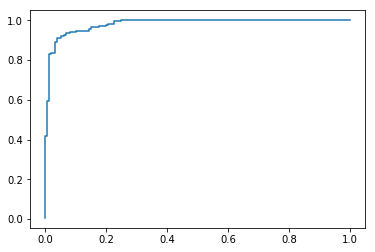

In [64]:
plt.plot(fpr, tpr, label='Target = 3')

In [81]:
fpr, tpr, thresholds = roc_curve(all5_3_test["target"], probas_5, pos_label=5)

In [82]:
roc_auc_score(all5_3_test["target"]==5, probas_5)

0.9806099397590361

In [83]:
auc(fpr,tpr)

0.9806099397590361

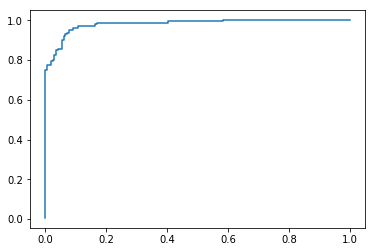

In [66]:
plt.plot(fpr, tpr, label='Target = 5')